# Gene regulatory analysis in IDH1 mutant glioma
- ZEB1 expression is increased in IHD1-mutant low grade glioma ([doi: 10.1007/s11060-016-2240-8](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6088798/))
- DBX2 Promotes Glioblastoma Cell Proliferation by Regulating REST Expression[DOI: 10.2174/1389201022666210830142827](https://pubmed.ncbi.nlm.nih.gov/34463226/) : related to REST

In [1]:
import numpy as np
import pandas as pd
import loompy as lp
import scanpy as sc
import anndata as ad
import pyscenic

import os
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
data_path = '/Users/jiehoonk/DevHub/mnt/dataset/lgg/output'
!ls {data_path}

1qc.h5ad
adj.csv
annotated.h5ad
annotated_with_cnvs.h5ad
annotated_with_cnvs_old.h5ad
combined.loom
copykat_result_copykat_CNA_raw_results_gene_by_cell.txt
copykat_result_copykat_CNA_results.txt
copykat_result_copykat_prediction.txt
copykat_result_copykat_with_genes_heatmap.pdf
deg
filtered.loom
fin_object.celloracle.oracle
integrated.h5ad
links.celloracle.links
model.model
obj.celloracle.oracle
reg.csv
scenic_out.loom
tumor_only.h5ad
tumor_with_OPC_COP.h5ad


In [3]:
def create_loom(adata, path):
    row = {"Gene": np.array(adata.var_names)}
    col = {"CellID": np.array(adata.obs_names),"nGene": np.array(np.sum(adata.X.transpose()>0 , axis=0)).flatten() ,"nUMI": np.array(np.sum(adata.X.transpose() , axis=0)).flatten()}
    matrix = adata.X.transpose()
    lp.create(path, matrix, row, col)

In [4]:
adata = sc.read_h5ad(os.path.join(data_path, 'annotated_with_cnvs.h5ad'))
adata

AnnData object with n_obs × n_vars = 21172 × 33697
    obs: 'sample_id', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'pct_counts_mt', 'pct_counts_ribo', 'pct_counts_hb', 'scDblFinder_score', 'scDblFinder_class', 'sample_description', '_scvi_batch', '_scvi_labels', 'over', 'jw_diagnosis', 'jw_anno', 'ct_anno', 'ct_conf_score', 'GFP', 'leiden_res3', 'tumor_score', '_scvi_raw_norm_scaling', 'Astro-like_score', 'Astrocytes_score', 'Cycling_score', 'Endothelial_score', 'Gradient_score', 'Microglia_score', 'Mixed_score', 'Neurons_score', 'Oligodendrocytes_score', 'OPC-like_score', 'Pericytes_score', 'RE_score', 'T Cell_score', 'cell_type', 'copykat.pred', 'cnv_leiden', 'cnv_score', 'cnv_status', 'mod_cell_type', 'low_cell_type'
    var: 'chromosome', 'start', 'end', 'gene_id', 'gene_name'
    uns: 'GFP_colors', '_scvi_manager_uuid', '_scvi_uuid', 'cell_type_colors', 'cnv', 'cnv_leiden_colors', 'cnv_neighbors',

In [10]:
adata.X = adata.layers['counts'].copy()
create_loom(adata, os.path.join(data_path, 'filtered.loom'))

In [16]:
tfs = [tf.strip() for tf in open('../../../annotations/mouse/allTFs_mm.txt')]
print(len(tfs))
print(f"{np.sum(adata.var.index.isin(tfs))} out of {len(tfs)} TFs are found in the object")

1860
1806 out of 1860 TFs are found in the object


In [ ]:
# run pyscenic pipeline
pyscenic grn filtered.loom ~/mnt/annotations/mouse/allTFs_mm.txt -o adj.csv --num_workers 36 && pyscenic ctx adj.csv ~/mnt/annotations/mouse/*.feather --annotations_fname ~/mnt/annotations/mouse/*.tbl --expression_mtx_fname filtered.loom --output reg.csv --mask_dropouts --num_workers 36 && pyscenic aucell filtered.loom reg.csv --output scenic_out.loom --num_workers 36

In [5]:
adjacencies = pd.read_csv(os.path.join(data_path, "adj.csv"), index_col=False, sep=',')
print(adjacencies.shape[0])
adjacencies.head()

9293859


,TF,target,importance
0,Rbm42,Cox6b1,414.228353
1,Rbm42,Usf2,391.617613
2,Rbm42,Psenen,358.671761
3,Usf2,Rbm42,356.081057
4,Jun,Jund,330.885087


In [6]:
regulons = {}
with lp.connect(os.path.join(data_path, 'scenic_out.loom'), mode="r+", validate=False) as lf:
    auc_mtx = pd.DataFrame(lf.ca.RegulonsAUC, index=lf.ca.CellID)
    exprMat = pd.DataFrame( lf[:,:], index=lf.ra.Gene, columns=lf.ca.CellID).T
    for i,r in pd.DataFrame(lf.ra.Regulons,index=lf.ra.Gene).items():
        regulons[i] =  list(r[r==1].index.values)

In [8]:
ad_auc_mtx = ad.AnnData(auc_mtx)
sc.pp.neighbors(ad_auc_mtx, n_neighbors=10, metric="correlation")
sc.tl.umap(ad_auc_mtx)
sc.tl.tsne(ad_auc_mtx)

         Falling back to preprocessing with `sc.pp.pca` and default params.


In [9]:
bdata = ad_auc_mtx.obs_names.intersection(adata.obs_names)
bdata = adata[adata.obs_names.isin(ad_auc_mtx.obs_names)]
bdata.obsm["X_umap_aucell"] = ad_auc_mtx.obsm["X_umap"]
bdata.obsm["X_tsne_aucell"] = ad_auc_mtx.obsm["X_tsne"]

/var/folders/9t/4v6202wn5_n62qf58gr7mf3r0000gn/T/ipykernel_53278/2561514935.py:3: ImplicitModificationWarning: Setting element `.obsm['X_umap_aucell']` of view, initializing view as actual.
  bdata.obsm["X_umap_aucell"] = ad_auc_mtx.obsm["X_umap"]


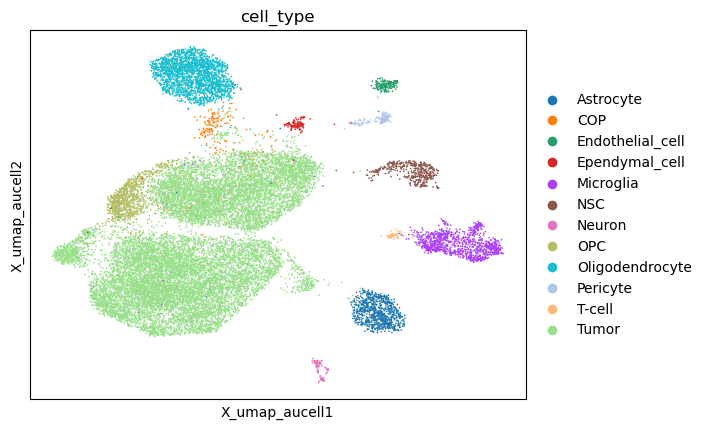

In [10]:
sc.pl.embedding(bdata, basis="X_umap_aucell", color="cell_type")

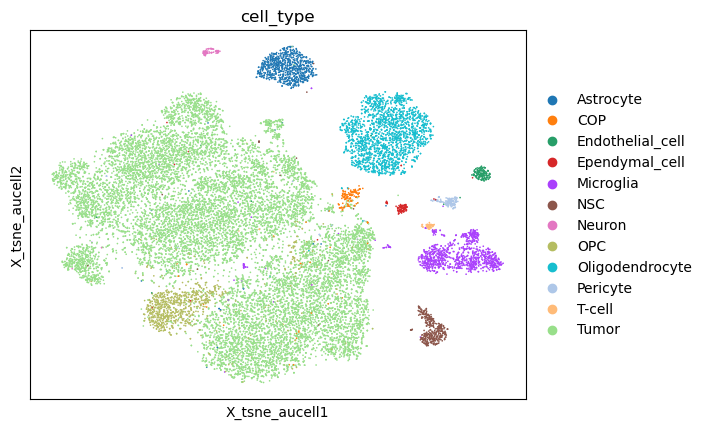

In [11]:
sc.pl.embedding(bdata, basis="X_tsne_aucell", color="cell_type")

In [13]:
bdata.obs["cell_type"].value_counts()

cell_type
Tumor               14948
Oligodendrocyte      2110
Microglia            1106
OPC                   944
Astrocyte             832
NSC                   431
COP                   178
Endothelial_cell      173
Pericyte              165
Ependymal_cell        119
Neuron                 96
T-cell                 70
Name: count, dtype: int64

In [14]:
ordered_cell = [
    'NSC', 'OPC', 'COP', 'Oligodendrocyte', 'Tumor', 'Astrocyte', 'Neuron', 'Ependymal_cell', 'Endothelial_cell', 'Pericyte', 'Microglia', 'T-cell', 
]
bdata.obs['cell_type'] = pd.Categorical(values = bdata.obs['cell_type'], categories = ordered_cell, ordered = True)

In [15]:
auc_mtx["cell_type"] = bdata.obs["cell_type"]
mean_auc_by_cell_type = auc_mtx.groupby("cell_type").mean()


/var/folders/9t/4v6202wn5_n62qf58gr7mf3r0000gn/T/ipykernel_53278/3585918495.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_auc_by_cell_type = auc_mtx.groupby("cell_type").mean()


In [16]:
top_n = 50
top_tfs = mean_auc_by_cell_type.max(axis=0).sort_values(ascending=False).head(top_n)
mean_auc_by_cell_type_top_n = mean_auc_by_cell_type[
    [c for c in mean_auc_by_cell_type.columns if c in top_tfs]
]

In [17]:
coi = ["NSC", "OPC", "COP", "Tumor", "Oligodendrocyte",]

In [18]:
auc_coi = mean_auc_by_cell_type_top_n.loc[coi, :]

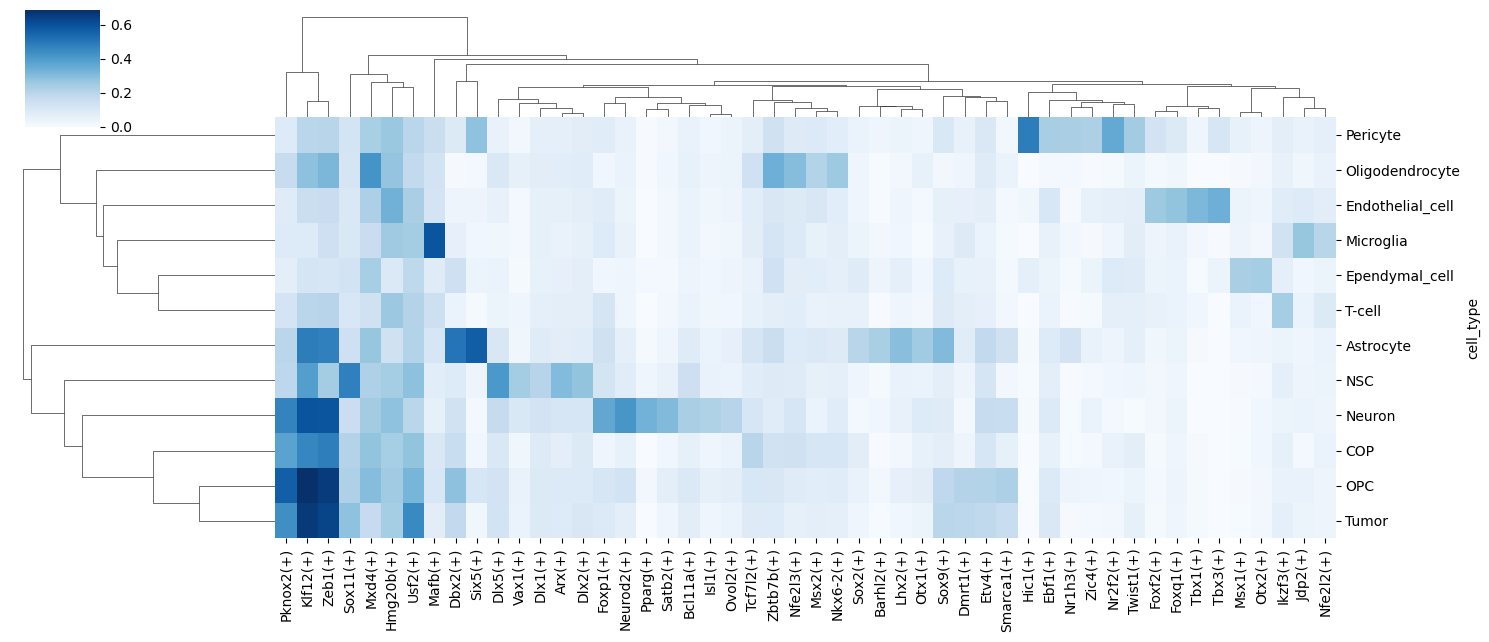

In [19]:
sns.clustermap(
    mean_auc_by_cell_type_top_n,
    figsize=[15, 6.5],
    cmap="Blues",
    xticklabels=True,
    yticklabels=True,
)

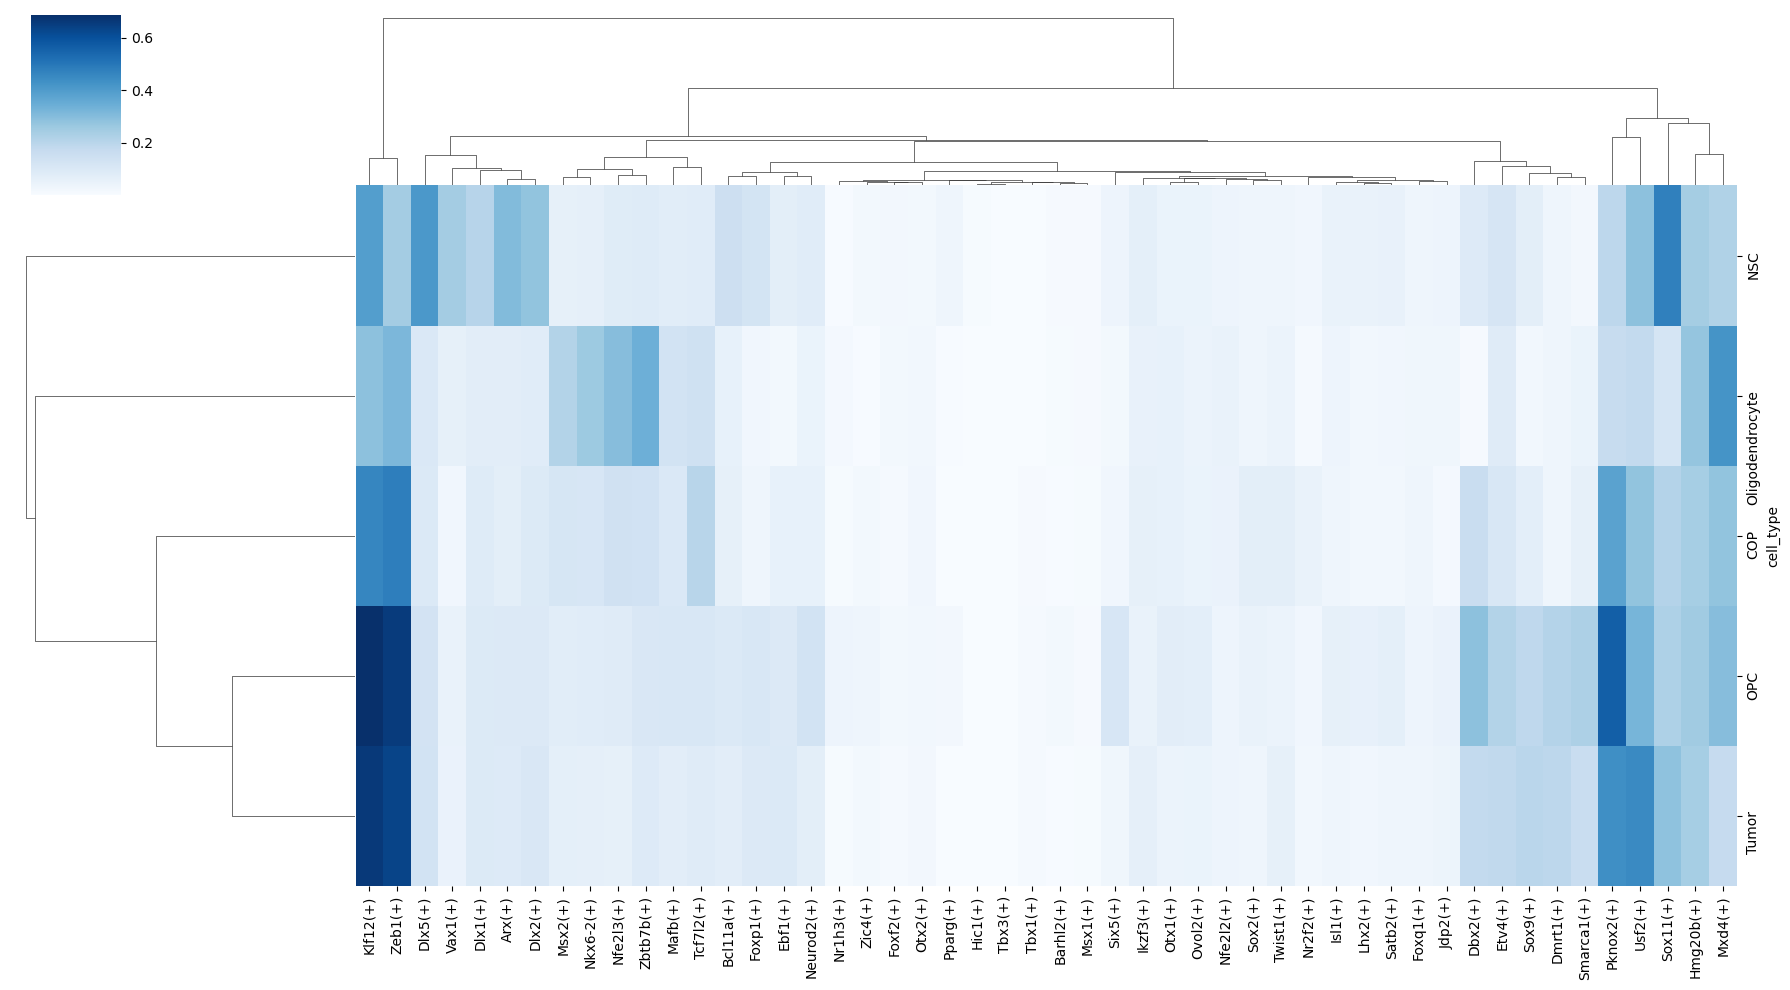

In [29]:
g = sns.clustermap(
    auc_coi,
    figsize=[18, 10],
    cmap="Blues",
    xticklabels=True,
    yticklabels=True,
)
# Rotate the y-axis labels 90 degrees clockwise
for item in g.ax_heatmap.get_yticklabels():
    item.set_rotation(90)
plt.show()

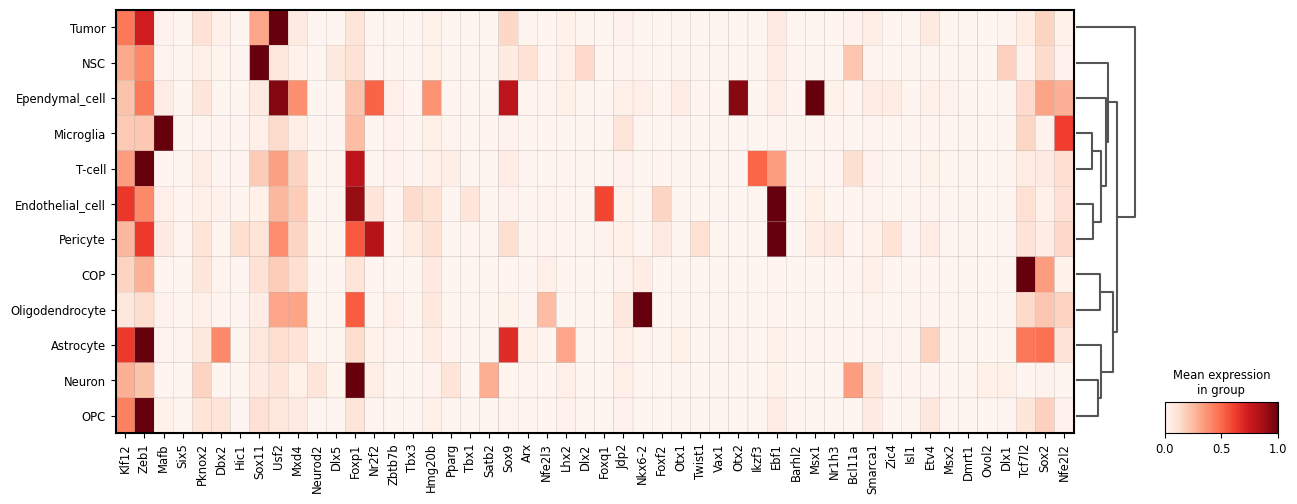

In [24]:
tf_names = top_tfs.index.str.replace("(+)", "")
gbm_subset_top_tfs = bdata[:, bdata.var_names.isin(tf_names)]

sc.pl.matrixplot(
    adata,
    tf_names,
    groupby="cell_type",
    cmap="Reds",
    dendrogram=True,
    figsize=[15, 5.5],
    standard_scale="group",
)


In [31]:
top_tfs

Klf12(+)      0.709435
Zeb1(+)       0.668691
Mafb(+)       0.586798
Six5(+)       0.563523
Pknox2(+)     0.522787
Dbx2(+)       0.506157
Hic1(+)       0.484263
Sox11(+)      0.476595
Usf2(+)       0.465628
Mxd4(+)       0.421809
Neurod2(+)    0.415855
Dlx5(+)       0.408589
Foxp1(+)      0.362503
Nr2f2(+)      0.357879
Zbtb7b(+)     0.339883
Tbx3(+)       0.339285
Hmg20b(+)     0.333815
Pparg(+)      0.329673
Tbx1(+)       0.311930
Satb2(+)      0.307311
Sox9(+)       0.306833
Arx(+)        0.305337
Nfe2l3(+)     0.295144
Lhx2(+)       0.294476
Dlx2(+)       0.277348
Foxq1(+)      0.275897
Jdp2(+)       0.267993
Nkx6-2(+)     0.258849
Foxf2(+)      0.258309
Otx1(+)       0.252744
Twist1(+)     0.248756
Vax1(+)       0.244620
Otx2(+)       0.242468
Ikzf3(+)      0.241529
Ebf1(+)       0.237485
Barhl2(+)     0.233997
Msx1(+)       0.232977
Nr1h3(+)      0.232235
Bcl11a(+)     0.231346
Zic4(+)       0.226177
Etv4(+)       0.222340
Isl1(+)       0.218114
Msx2(+)       0.212201
Smarca1(+) 